In [ ]:
#autor: Patryk Klytta
#data: 10.01.2025

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:

!wget http://www.kasprowski.pl/datasets/adversarial/signs_model.h5
!wget http://www.kasprowski.pl/datasets/adversarial/signs_labels.csv
!wget http://www.kasprowski.pl/datasets/adversarial/stop.jpg



--2025-01-10 07:26:44--  http://www.kasprowski.pl/datasets/adversarial/signs_model.h5
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50732024 (48M) [text/plain]
Saving to: ‘signs_model.h5’

signs_model.h5      100%[===================>]  48.38M  11.1MB/s    in 6.0s    

2025-01-10 07:26:51 (8.09 MB/s) - ‘signs_model.h5’ saved [50732024/50732024]

--2025-01-10 07:26:51--  http://www.kasprowski.pl/datasets/adversarial/signs_labels.csv
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [text/csv]
Saving to: ‘signs_labels.csv’

signs_labels.csv    100%[===================>]   1.02K  --.-KB/s    in 0s      

2025-01-10 07:26:51 (109 MB/s) - ‘signs_labels.csv’ saved [1041

In [3]:
model = tf.keras.models.load_model("signs_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [4]:
image = cv2.imread("stop.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64, 64))
image = np.expand_dims(image, axis=0).astype(np.float32)

In [5]:
classes = pd.read_csv("signs_labels.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Obraz pierwotnie klasyfikowany jako Stop z prawdopodobieństwem 0.96


<ipython-input-10-62ab44449376>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Obraz pierwotnie klasyfikowany jako {classes.loc[original_class][1]} z prawdopodobieństwem {pred[0][original_class]:.2f}")
<ipython-input-10-62ab44449376>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f"Original: {classes.loc[original_class][1]}")


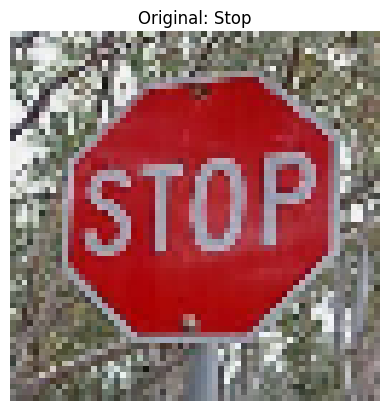

In [10]:
pred = model.predict(image)
original_class = np.argmax(pred)
print(f"Obraz pierwotnie klasyfikowany jako {classes.loc[original_class][1]} z prawdopodobieństwem {pred[0][original_class]:.2f}")

plt.imshow(image[0].astype(np.uint8))
plt.title(f"Original: {classes.loc[original_class][1]}")
plt.axis("off")
plt.show()

In [40]:
def do_step(image, delta, real_class, target_class, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        adversary = tf.clip_by_value(image + delta, 0, 255)
        predictions = model(adversary, training=False)

        original_loss = loss_fn(tf.convert_to_tensor([real_class]), predictions)
        target_loss = loss_fn(tf.convert_to_tensor([target_class]), predictions)
        loss = target_loss - original_loss

    gradients = tape.gradient(loss, delta)
    gradients = tf.clip_by_norm(gradients, 2.0)
    optimizer.apply_gradients([(gradients, delta)])
    delta.assign_add(tf.clip_by_value(delta, -0.01, 0.01))

    return delta, loss

In [51]:
target_class = 12  # Priority road
real_class = 14   # Stop
delta = tf.Variable(tf.zeros_like(image), trainable=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2)  
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
steps = 100

In [52]:
def show_step(image, delta, loss, step, real_class, target_class, classes, output_dir="output"):
    adversary_image = tf.clip_by_value(image + delta, 0, 255).numpy()
    predictions = model(adversary_image, training=False)[0]
    top_indices = tf.argsort(predictions, direction='DESCENDING')[:2]
    top_probs = [(classes.loc[i.numpy()][1], predictions[i.numpy()]) for i in top_indices]

    print(f"Step: {step}, Loss: {loss.numpy():.4f}")
    print("Predicition:")
    for i, (label, prob) in enumerate(top_probs):
        print(f"{i + 1}. {label}: {prob * 100:.2f}%")

    # Tworzenie wizualizacji
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(image[0].astype(np.uint8))
    plt.title(f"Original: {classes.loc[real_class][1]}")
    plt.axis("off")
    ax2 = plt.subplot(1, 3, 2)
    plt.imshow((delta[0].numpy() * 128 + 128).astype(np.uint8))
    plt.title("Delta")
    plt.axis("off")
    ax3 = plt.subplot(1, 3, 3)
    plt.imshow(adversary_image[0].astype(np.uint8))
    plt.title(f"Adversary: {top_probs[0][0]} ({top_probs[0][1] * 100:.2f}%)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    os.makedirs(output_dir, exist_ok=True)
    image_name = f"adversarial_step_{step:03d}.jpg"
    cv2.imwrite(
        os.path.join(output_dir, image_name),
        cv2.cvtColor(adversary_image[0].astype(np.uint8), cv2.COLOR_RGB2BGR)
    )


<ipython-input-52-8a6fe63c5810>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_probs = [(classes.loc[i.numpy()][1], predictions[i.numpy()]) for i in top_indices]
<ipython-input-52-8a6fe63c5810>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f"Original: {classes.loc[real_class][1]}")


Step: 0, Loss: 41.8627
Predicition:
1. Stop: 90.21%
2. No entry: 9.79%


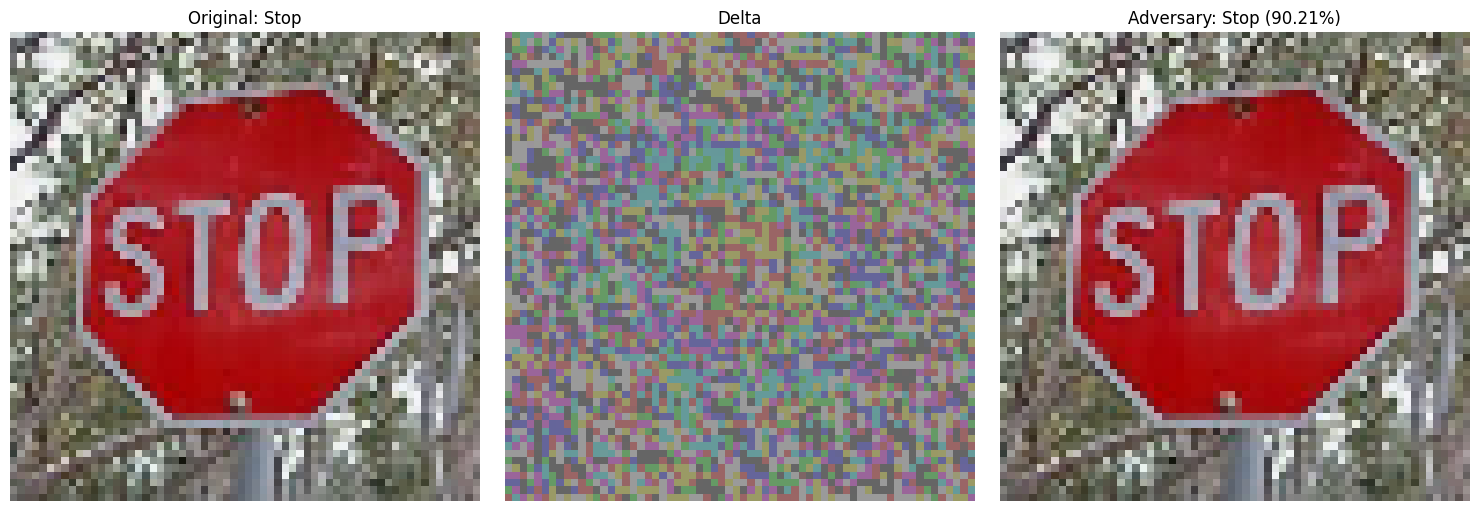

Step: 10, Loss: 24.9943
Predicition:
1. No entry: 99.89%
2. Stop: 0.11%


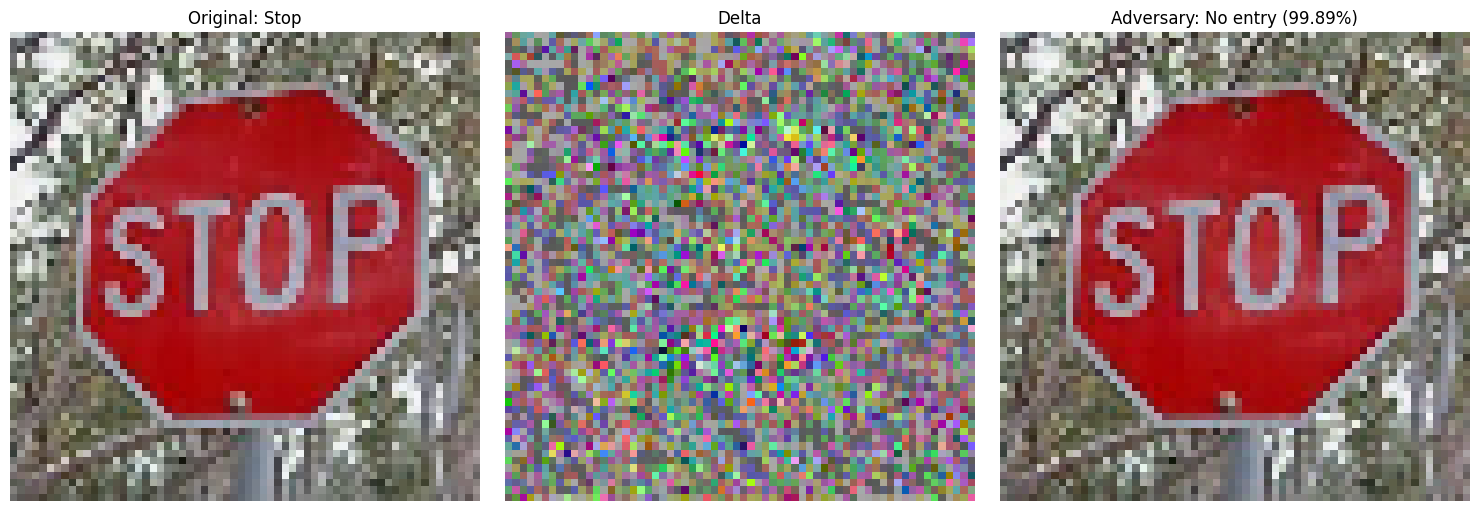

Step: 20, Loss: 10.1525
Predicition:
1. No entry: 100.00%
2. Stop: 0.00%


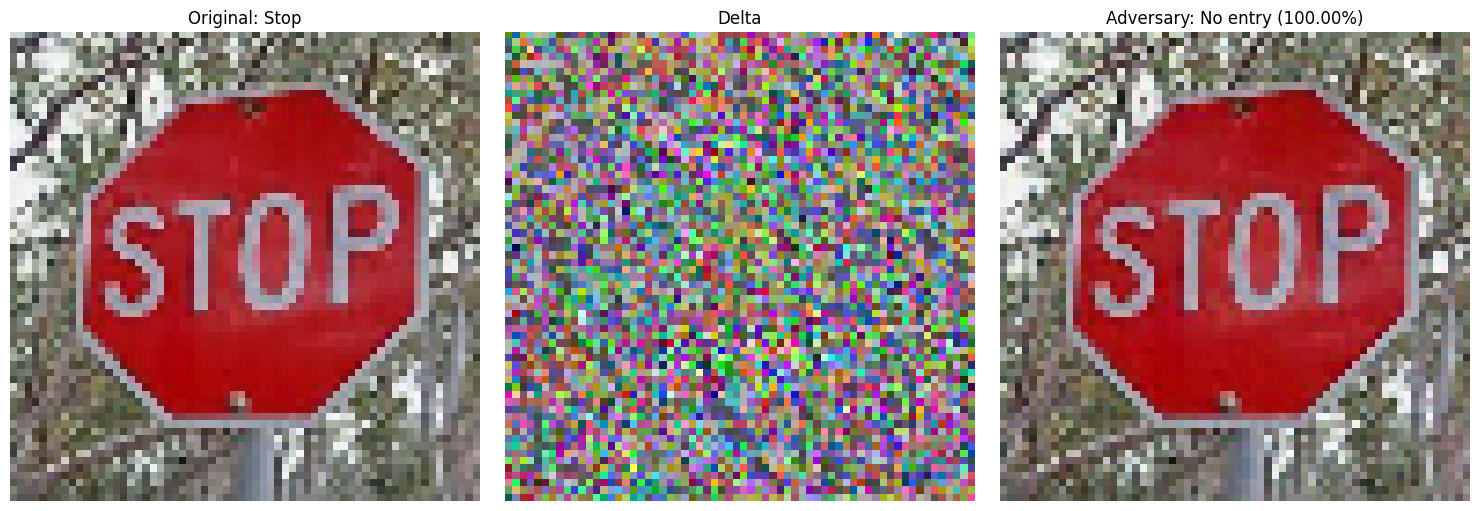

Step: 30, Loss: -3.2475
Predicition:
1. No entry: 100.00%
2. Priority road: 0.00%


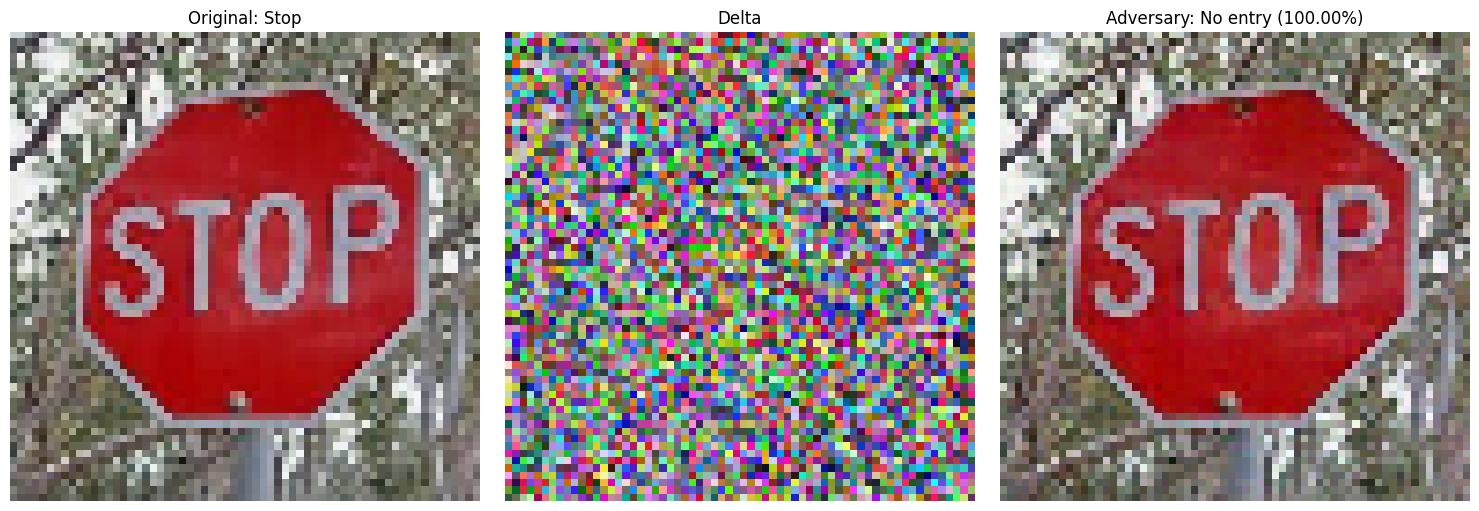

Step: 40, Loss: -16.2113
Predicition:
1. No entry: 100.00%
2. Priority road: 0.00%


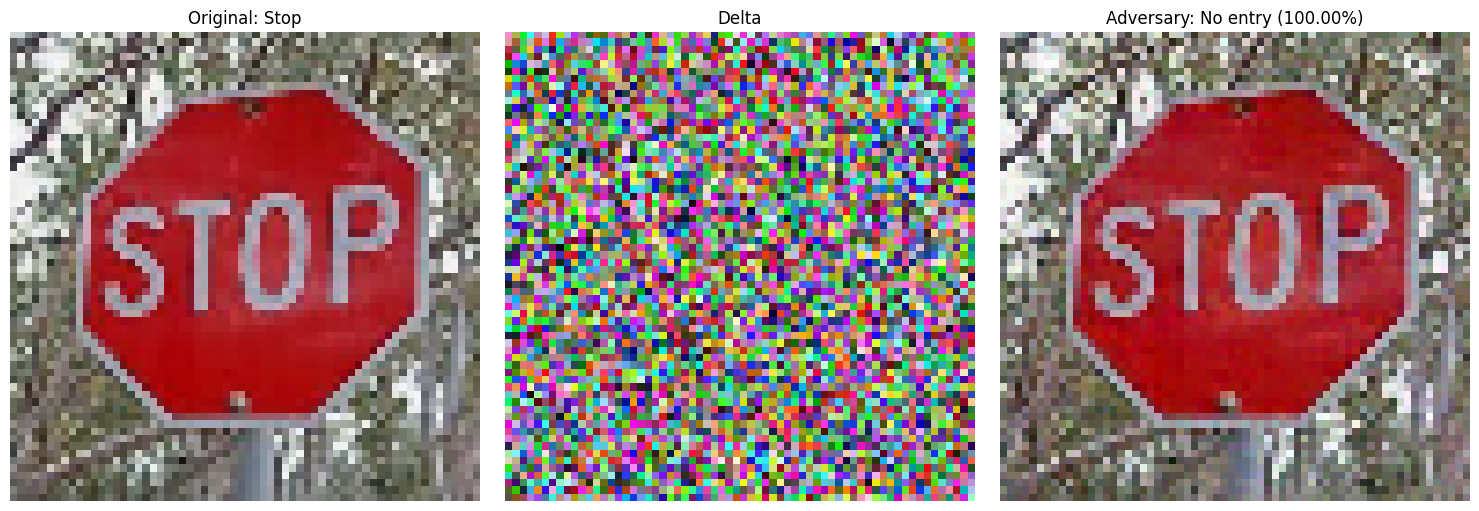

Step: 50, Loss: -29.0378
Predicition:
1. No entry: 99.84%
2. Priority road: 0.16%


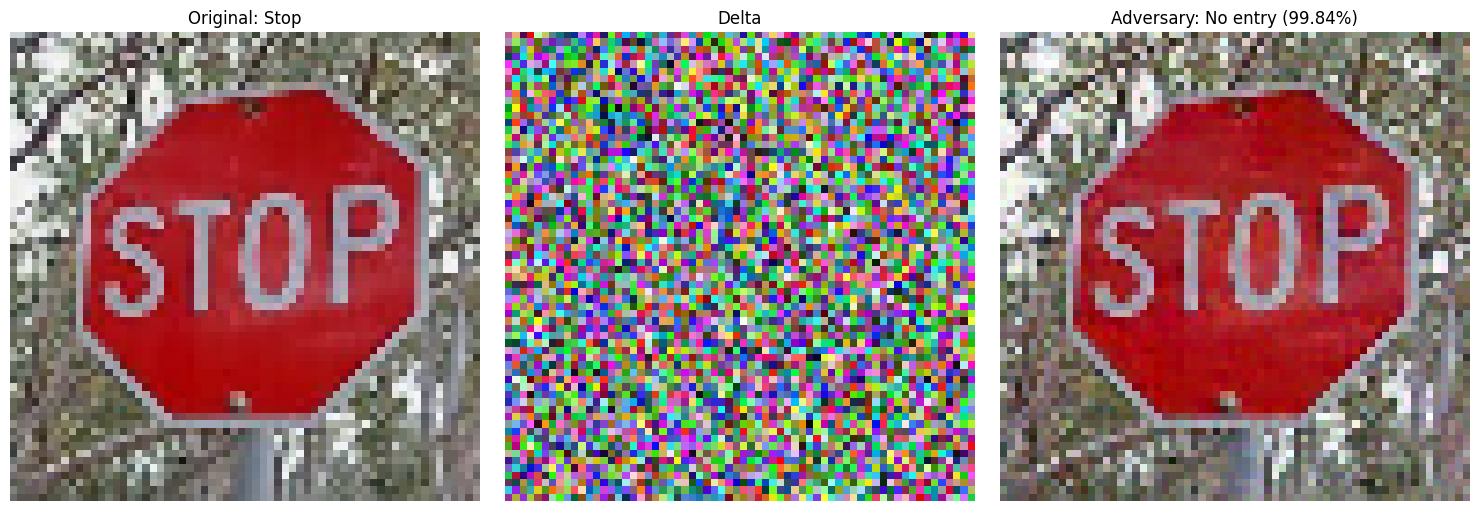

Step: 60, Loss: -41.6296
Predicition:
1. No entry: 76.10%
2. Priority road: 23.90%


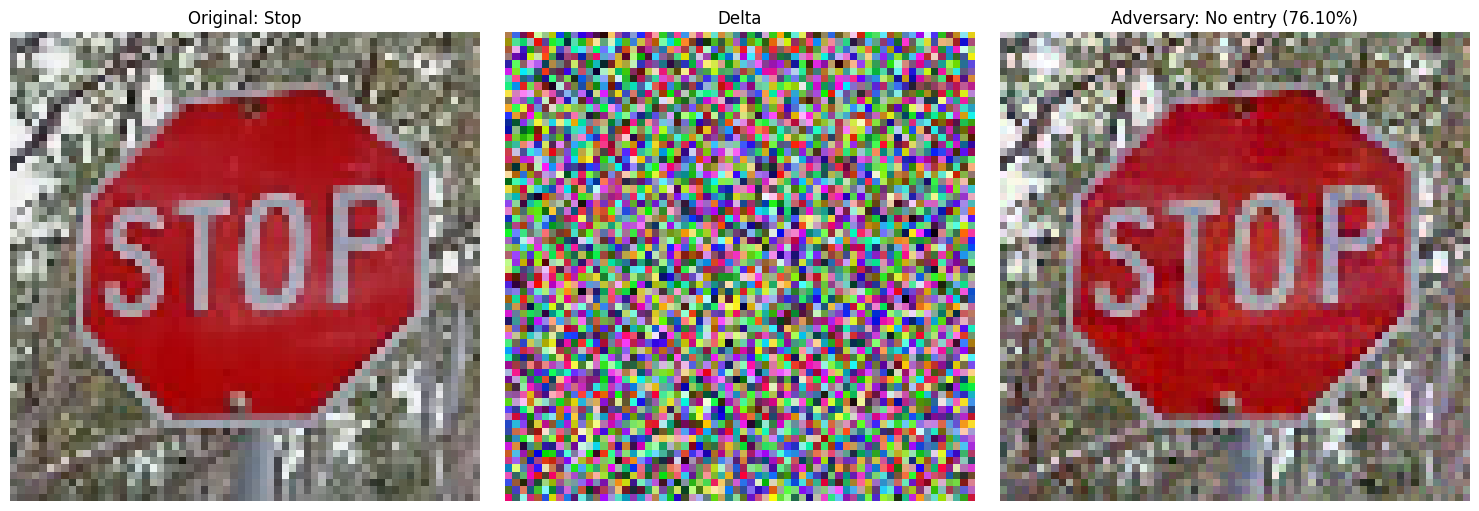

Step: 70, Loss: -53.2840
Predicition:
1. Priority road: 99.38%
2. No entry: 0.62%


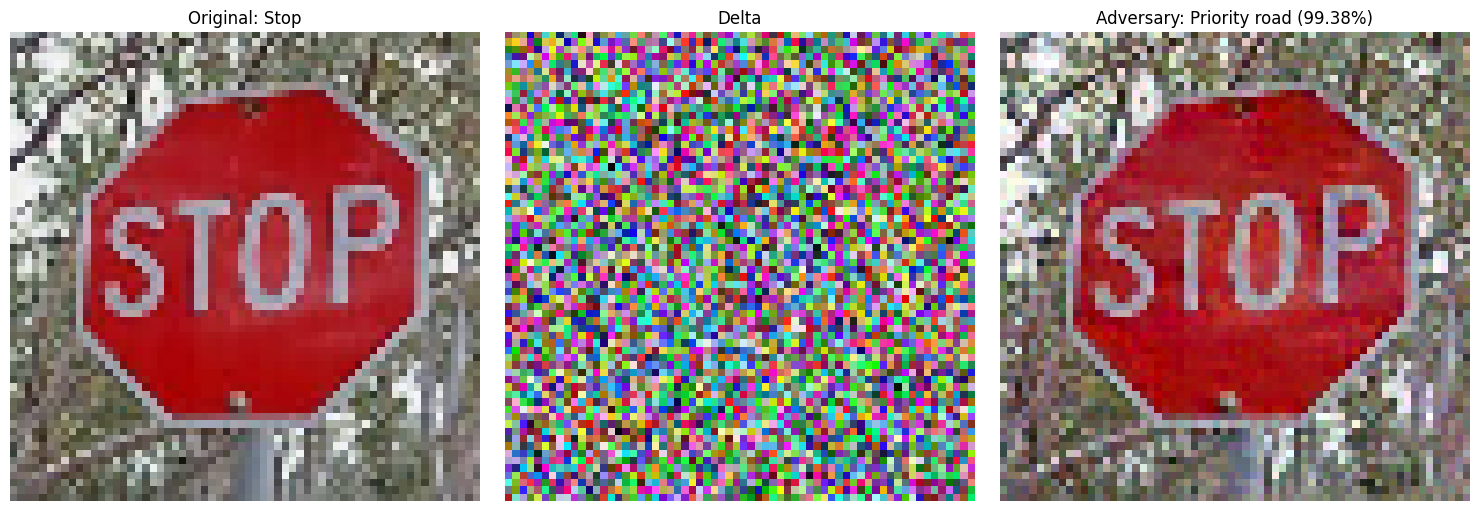

Step: 80, Loss: -64.5766
Predicition:
1. Priority road: 100.00%
2. No entry: 0.00%


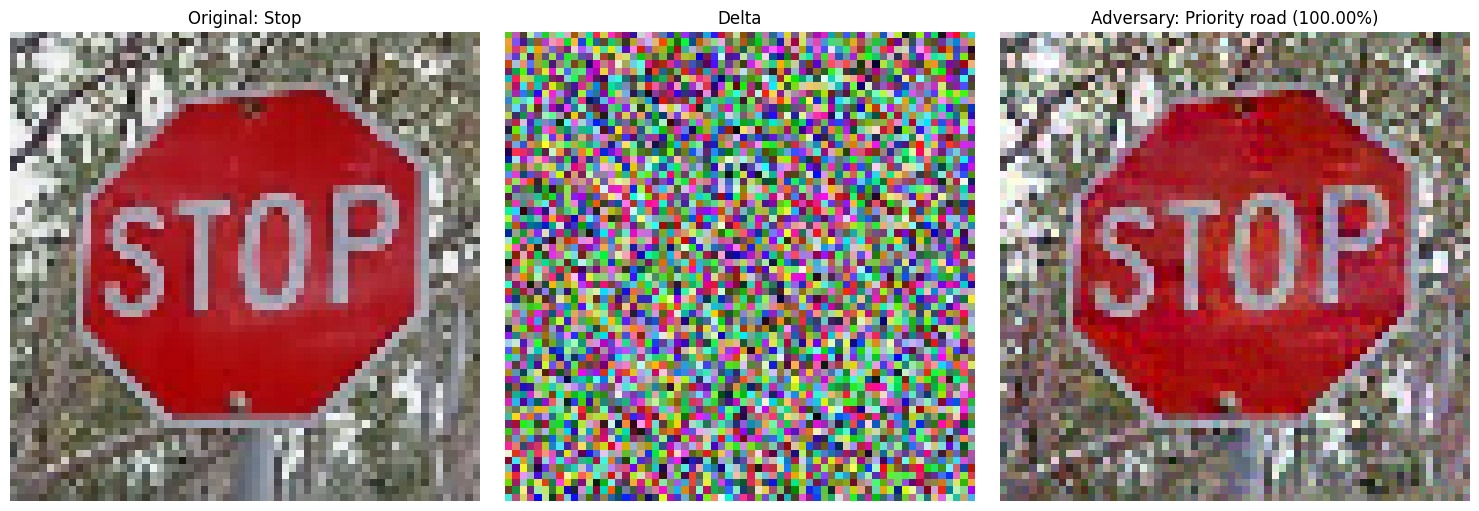

Step: 90, Loss: -75.7752
Predicition:
1. Priority road: 100.00%
2. No passing: 0.00%


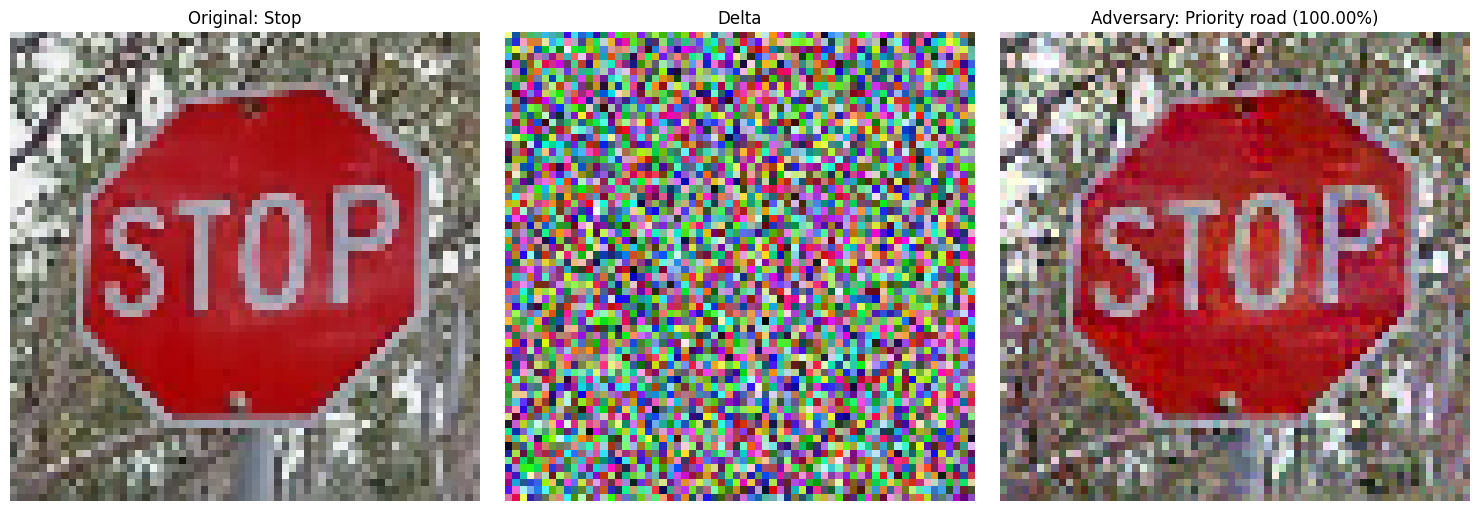

Step: 99, Loss: -85.7454
Predicition:
1. Priority road: 100.00%
2. No passing: 0.00%


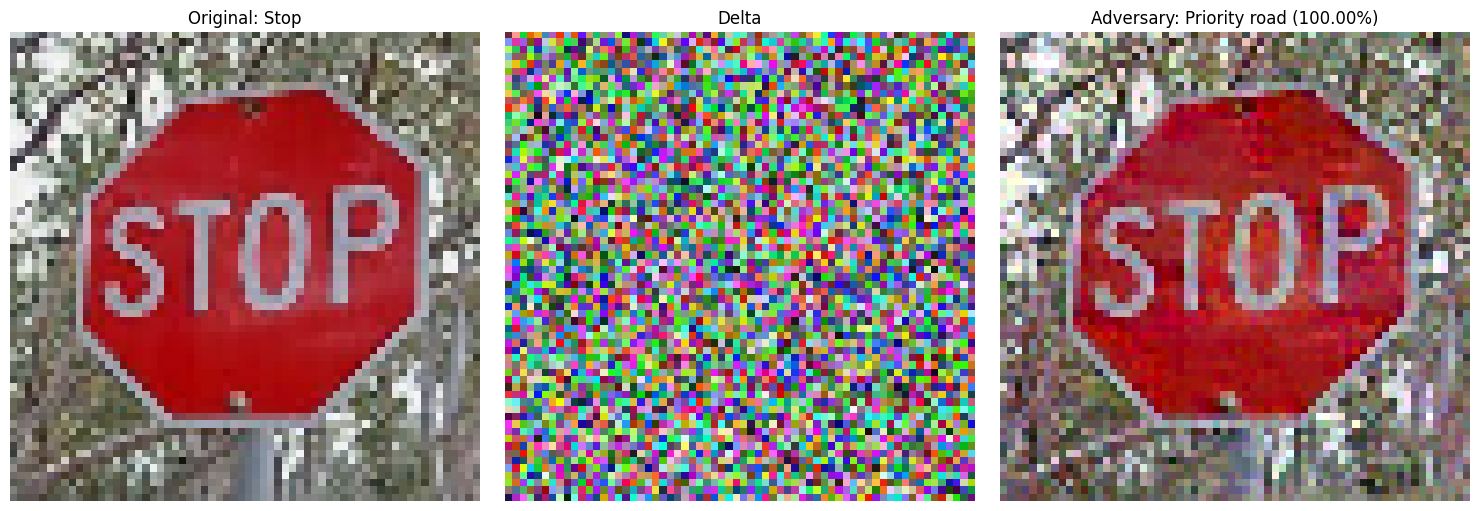

Atak zakończony.


In [53]:
import os

for step in range(steps):
    delta, loss = do_step(image, delta, real_class, target_class, optimizer, loss_fn)
    if step % 10 == 0 or step == steps - 1:
        show_step(image, delta, loss, step, real_class, target_class, classes)

print("Atak zakończony.")

- Wykorzystanie techniki ataku pozwoliło stworzyć obraz, który wizualnie przypomina oryginalny znak "Stop", lecz jest klasyfikowany przez model jako znak "Priority road".

- Finalna zmiana klasyfikacji wskazuje na sukces ataku, przy czym dla ludzkiego oka obraz nie traci swojej pierwotnej interpretacji.

- wyższa wartość parametru learning_rate pozwala na szybsze sklasyfikowanie obrazu jako Priority Road ale zmniejsza również znacząco loss (dużo na minusie, ok. -90). Stąd wartość learning_rate=0,2 wydaje sie być optymalna, gdyż pozwala na poprawne sklasyfikowanie i pozwala osiągnąc loss na poziomie ok. -90 i prawdopodobieństwo predykcji równe 100%.

- Atak adversarialny został przeprowadzony skutecznie. Ostateczna klasyfikacja zgodnie z założeniami wskazuje na podatność modeli głębokiego uczenia na tego typu działania.
